### Introduction to Machine Learning for Sentiment Analysis

In [4]:
%matplotlib inline
datadir = './data/'

import urllib.request, os, gzip

def download_data(dataset_name, datadir):
    filename = 'reviews_%s_5.json' % dataset_name
    filepath = os.path.join(datadir, filename)
    if os.path.exists(filepath):
        print("Dataset %s has already been downloaded to %s" % (dataset_name, datadir))
    else:
        url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/%s.gz' % filename
        urllib.request.urlretrieve(url, filepath + ".gz")
        with gzip.open(filepath + ".gz", 'rb') as fin:
            with open(filepath, 'wb') as fout:
                fout.write(fin.read())
        print("Downloaded dataset %s and saved it to %s" % (dataset_name, datadir))

dataset = "Baby"
download_data(dataset, datadir)

Downloaded dataset Baby and saved it to ./data/


In [5]:
import json

def load_data(dataset_name, datadir):
    filepath = os.path.join(datadir, 'reviews_%s_5.json' % dataset_name)
    if not os.path.exists(filepath):
        download_data(dataset_name, datadir)
    data = []
    with open(filepath, 'r') as f:
        for line in f:                            # read file line by line
            item_hash = hash(line)                # we will use this later for partitioning our data 
            item = json.loads(line)               # convert JSON string to Python dict
            item['hash'] = item_hash              # add hash for identification purposes
            data.append(item)
    print("Loaded %d data for dataset %s" % (len(data), dataset_name))
    return data

# load the data...
baby = load_data(dataset, datadir)
# ... and have a look at an example item (item number 9426):
print(baby[9426])
#for i, l in enumerate(baby):
#    if l['overall'] == 5.0 and 'horrible' in l['reviewText'] and 'bad' in l['reviewText'] and l['helpful'][0]>0:
#        print(i, l['reviewText'])

Loaded 160792 data for dataset Baby
{'reviewerID': 'A2H4QWDVXARPAU', 'asin': 'B0000TYHD2', 'reviewerName': 'Erin White "Erin"', 'helpful': [7, 8], 'reviewText': "I bought this pump for my new baby because it just as others below have said it looks more comfortable than others and it is! Including Medela. With my other child I encountered breastfeeding problems and had a horrible cheap pump. Now with my new baby she was born with a heart problem (she is fine now after a long road to recovery) and had to stay in the hospital for an extended length of time. Meanwhile I had other children at home and we live 6 hours away from our family and so I had no choice but to divide my time between the hospital and home, which meant I needed a hospital grade pump originally I rented one from the hospital (Medela) and it made my breasts hurt really bad. On the way home from the hospital I stopped in at Babiesrus and bought this pump because it was on our registry (we studied and found it to be more c

In [6]:
def partition_train_validation_test(data):
    # 60% : modulus is 0, 1, 2, 3, 4, or 5
    data_train = [item for item in data if item['hash']%10<=5]  
    # 20% : modulus is 6 or 7
    data_valid = [item for item in data if item['hash']%10 in [6,7]] 
    # 20% : modulus is 8 or 9
    data_test  = [item for item in data if item['hash']%10 in [8,9]] 
    return data_train, data_valid, data_test
    
baby_train, baby_valid, baby_test = partition_train_validation_test(baby)

print("Now we have", len(baby_train), "training examples,", len(baby_valid),
      "validation examples, and", len(baby_test), "test examples")

Now we have 96635 training examples, 32243 validation examples, and 31914 test examples


In [7]:
from nltk.corpus import opinion_lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

import random
random.seed(1234)
print("Some positive words:", ", ".join(random.sample(positive_words, 10)))
print("Some negative words:", ", ".join(random.sample(negative_words, 10)))

intersection = positive_words & negative_words
print("Words that appear in both sets: " + ", ".join(intersection))

Some positive words: inventive, cooperatively, unforgettable, cleverly, reverently, positively, cute, wonderful, humane, revelation
Some negative words: nonexistent, morbid, snobby, unease, unprofitable, sue, frazzled, startlingly, dimmer, hobble
Words that appear in both sets: envious, enviousness, enviously


In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
eng_stopwords = set(stopwords.words('english'))

def my_tokenize(text):
    # split text into lower-case tokens, removing all-punctuation tokens and stopwords
    tokens = []
    for sentence in sent_tokenize(text):
        tokens.extend(x for x in word_tokenize(sentence.lower()) 
                      if x not in eng_stopwords and any(i.isalpha() for i in x))
    return tokens

def pos_neg_fraction(text):
    tokens = my_tokenize(text)
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in positive_words:
            count_pos += 1
        if t in negative_words:
            count_neg += 1
    count_all = len(tokens)
    if count_all != 0:
        return count_pos/count_all, count_neg/count_all
    else:
        return 0., 0.
    
pos_example = 'This is a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example = 'This is a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction(pos_example))
print(pos_neg_fraction(neg_example))

(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)


In [9]:
import numpy

def dataset_to_matrix(data):
    return numpy.array([list(pos_neg_fraction(item['reviewText'])) for item in data])

X_train = dataset_to_matrix(baby_train)
most_pos, most_neg = numpy.argmax(X_train, axis=0)
# print the example with the highest fraction of positive words:
print("We found a fraction of %f %% positive words for example %d" % 
      (100.*X_train[most_pos, 0], most_pos))
print(baby_train[most_pos])
print("We found a fraction of %f %% negative words for example %d" %
      (100.*X_train[most_neg, 1], most_neg))
print(baby_train[most_neg])

We found a fraction of 100.000000 % positive words for example 5827
{'reviewerID': 'AKU0ZZ3IEZW42', 'asin': 'B0001BUKA8', 'helpful': [0, 0], 'reviewText': 'useful peace', 'overall': 5.0, 'summary': 'Five Stars', 'unixReviewTime': 1405382400, 'reviewTime': '07 15, 2014', 'hash': -3100817711860601990}
We found a fraction of 100.000000 % negative words for example 25071
{'reviewerID': 'A1SLEYD29KEUW1', 'asin': 'B000WUD83O', 'reviewerName': 'ABDULLAH AL-FALAH', 'helpful': [0, 0], 'reviewText': 'too noisy', 'overall': 2.0, 'summary': 'Two Stars', 'unixReviewTime': 1404432000, 'reviewTime': '07 4, 2014', 'hash': -4314539978079151500}


In [10]:
def dataset_to_targets(data):
    return numpy.array([item['overall'] for item in data])

Y_train = dataset_to_targets(baby_train)
print("Our feature matrix is two-dimensional and has shape", X_train.shape)
print("Our target vector is one-dimensional and has shape", Y_train.shape)

Our feature matrix is two-dimensional and has shape (96635, 2)
Our target vector is one-dimensional and has shape (96635,)


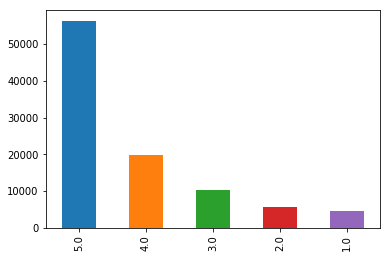

In [11]:
import pandas
pandas.Series(Y_train).value_counts().plot.bar()

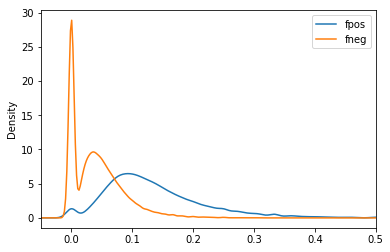

In [12]:
df = pandas.DataFrame(data=X_train, columns = ['fpos', 'fneg'])
df.plot.kde(xlim=(-0.05, 0.5))